<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
Epoch: 100, MSE: 0.026761
Epoch: 200, MSE: 0.024696
Epoch: 300, MSE: 0.022623
Epoch: 400, MSE: 0.018416
Epoch: 500, MSE: 0.013206
Epoch: 600, MSE: 0.009391
Epoch: 700, MSE: 0.006929
Epoch: 800, MSE: 0.005489
Epoch: 900, MSE: 0.004630
Epoch: 1000, MSE: 0.004010
Epoch: 1100, MSE: 0.003545
Epoch: 1200, MSE: 0.003325
Epoch: 1300, MSE: 0.002806
Epoch: 1400, MSE: 0.002499
Epoch: 1500, MSE: 0.002211
Epoch: 1600, MSE: 0.001965
Epoch: 1700, MSE: 0.001998
Epoch: 1800, MSE: 0.001566
Epoch: 1900, MSE: 0.001461
Epoch: 2000, MSE: 0.001291
Epoch: 2100, MSE: 0.001577
Epoch: 2200, MSE: 0.001097
Epoch: 2300, MSE: 0.001012
Epoch: 2400, MSE: 0.000951
Epoch: 2500, MSE: 0.000879
Epoch: 2600, MSE: 0.001042
Epoch: 2700, MSE: 0.000761
Epoch: 2800, MSE: 0.000700
Epoch: 2900, MSE: 0.000679
Epoch: 3000, MSE: 0.000598
Epoch: 3100, MSE: 0.003129
Epoch: 3200, MSE: 0.000509
Epoch: 3300, MSE: 0.000462
Epoch: 3400, MSE: 0.000501
Epoch: 3500, MSE: 0.000392
Epoch: 3600, MSE: 0.000354
Epoch: 3700, MSE: 0.000339
Epoch

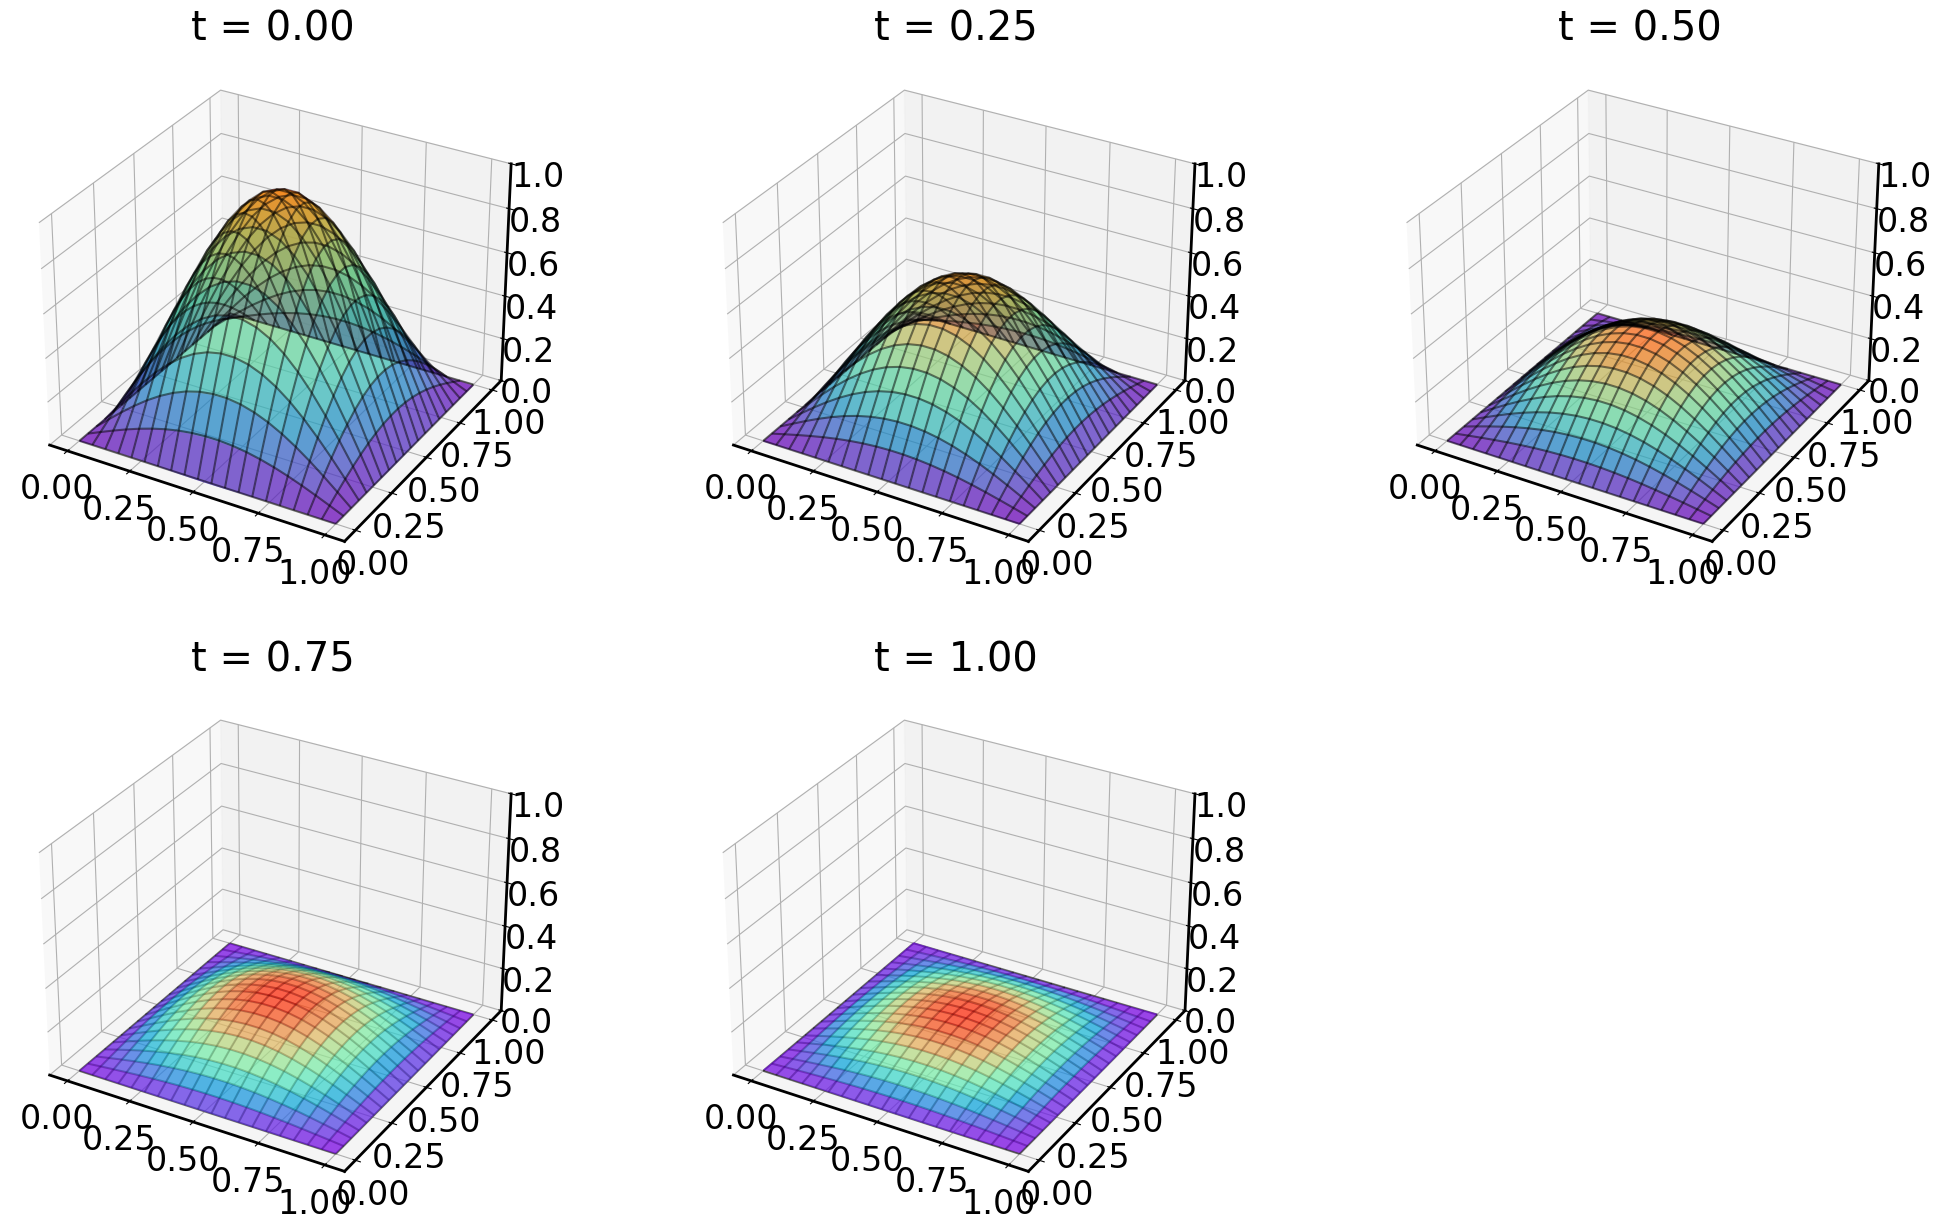

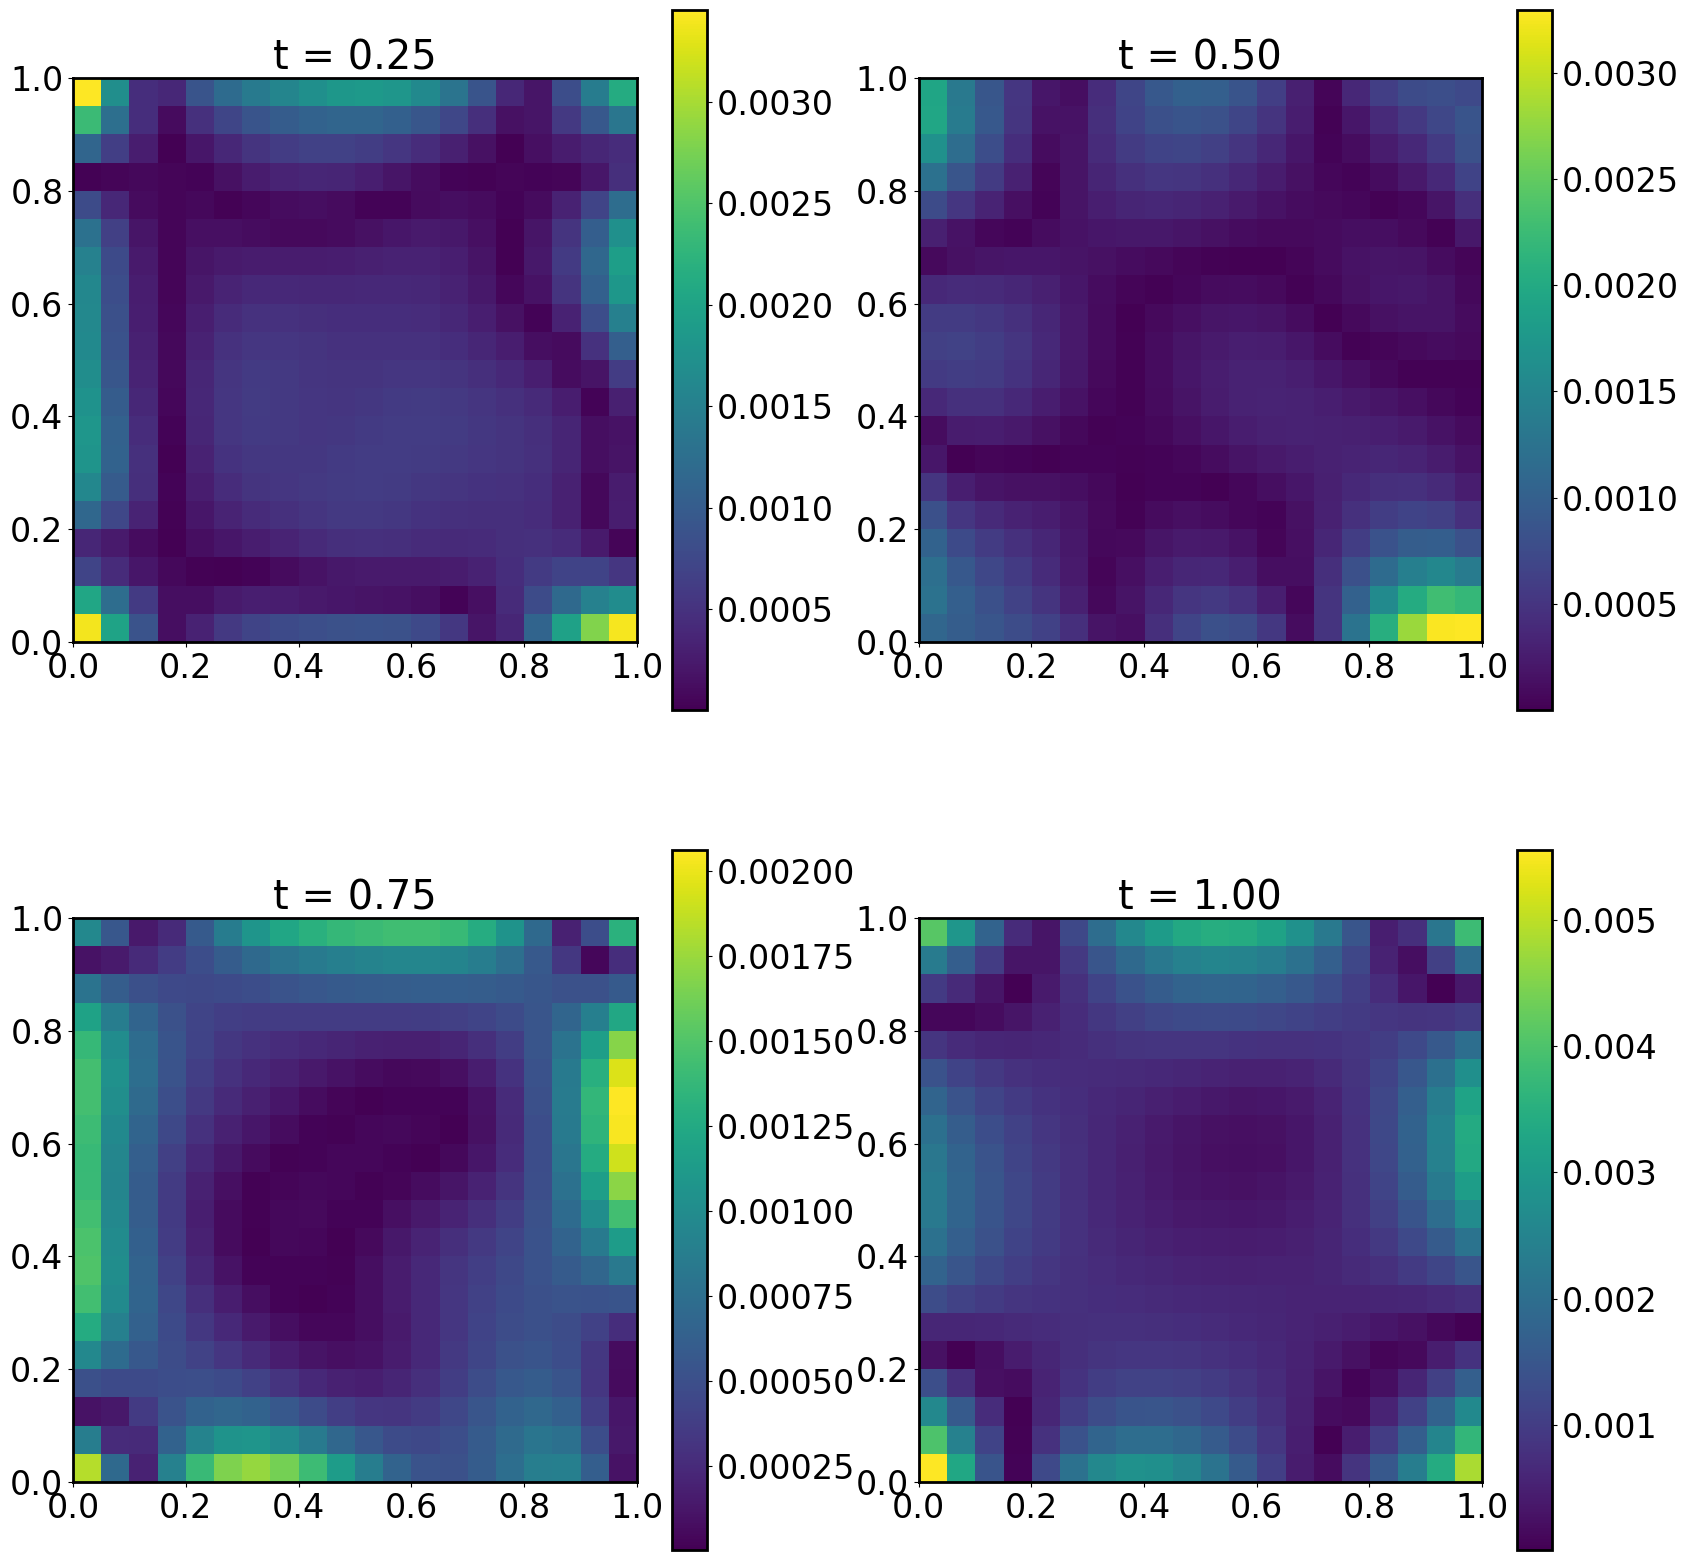

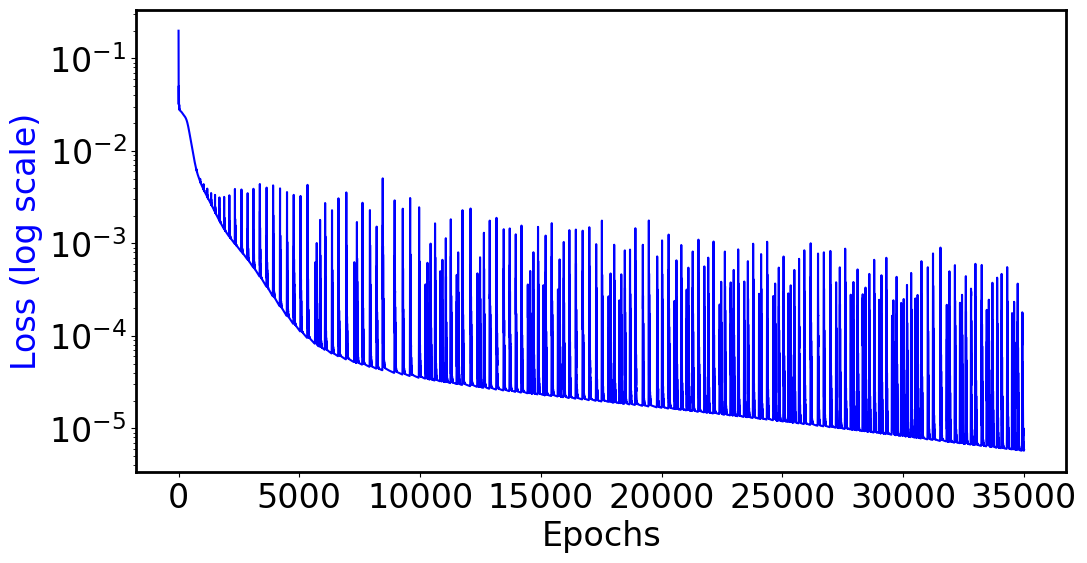

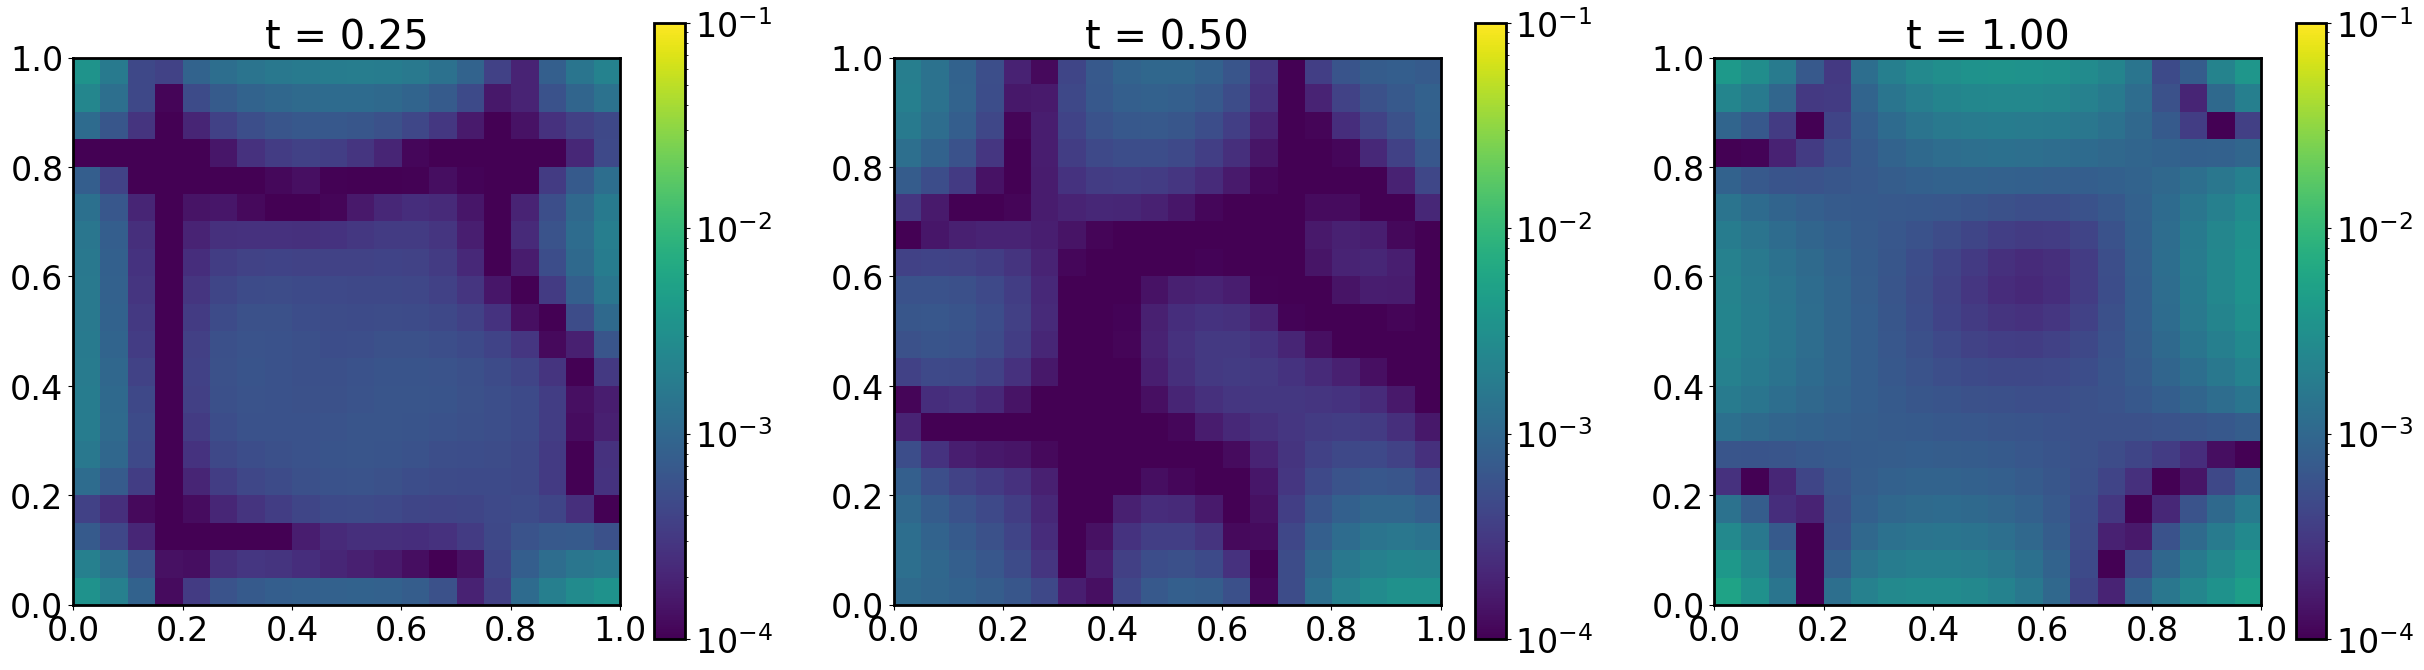

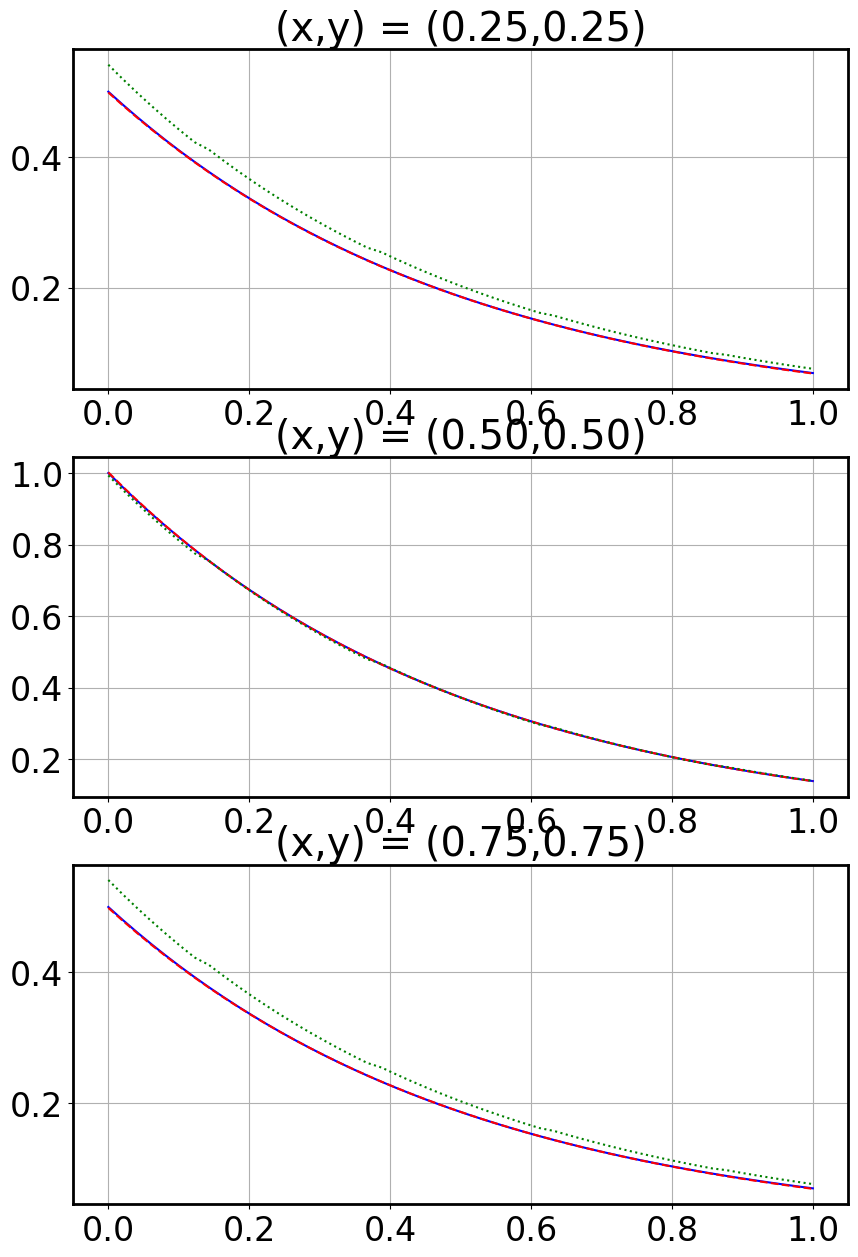

In [13]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
import time
import scipy.special as sp
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc_init(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [0]]
        u_yy = torch.autograd.grad(u_y, x_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x, y, x_to_train_f):
        loss_u = self.loss_bc_init(x, y)
        loss_f = self.loss_initernal(x_to_train_f)
        return loss_u + loss_f

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])

def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    x_bound = np.vstack([lower_x, upper_x, right_y, left_y])
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:, None], [Nx * 4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext = np.zeros((Nx * 4 * Nt))[:, None]
    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    ldx = np.random.permutation(all_Init_bcs.shape[0])
    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train

N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
D = 0.1

# Generate training data
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_y, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)

# Model setup
neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)

# Training loop
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
A_hist = []
max_iter = 35000
tic = time.time()

for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 100 == 0:
        print(f"Epoch: {i+1}, MSE: {loss.detach().cpu().item():.6f}")

toc = time.time()
print(f'Total training time: {(toc - tic)/60:.2f} minutes')

# FDM Simulation
def run_2d_fdm_simulation():
    points = 20
    x = np.linspace(0, 1, points)
    y = np.linspace(0, 1, points)
    delta_x = x[1] - x[0]
    delta_y = y[1] - y[0]
    delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * D)
    t_points = int(1.0/delta_t)
    t = np.linspace(0, 1, t_points)
    u = np.zeros((len(t), len(x), len(y)))

    # Initial condition
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    u[0,1:-1,1:-1] = np.sin(np.pi*X) * np.sin(np.pi*Y)

    # Time integration
    for n in range(len(t)-1):
        for i in range(1, len(x)-1):
            for j in range(1, len(y)-1):
                u[n+1,i,j] = u[n,i,j] + delta_t*D*(
                    (u[n,i+1,j] - 2*u[n,i,j] + u[n,i-1,j])/delta_x**2 +
                    (u[n,i,j+1] - 2*u[n,i,j] + u[n,i,j-1])/delta_y**2
                )
        # Boundary conditions
        u[n+1,[0,-1],:] = 0
        u[n+1,:,[0,-1]] = 0
    return x, y, t, u

x_fdm, y_fdm, t_fdm, u_fdm = run_2d_fdm_simulation()

def analytical_solution(x, y, t, D):
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.exp(-2*(np.pi**2)*D*t)

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

def plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25, 15))

    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6, label='PINN')
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3, label='Analytical')
        ax.plot_wireframe(X, Y, u_fdm[fdm_idx], color='black', alpha=0.5, label='FDM')
        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)
    plt.savefig('3D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

        err = np.abs(pinn - analytic)
        im = ax.imshow(err.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(np.array(A_hist)[:,0], np.array(A_hist)[:,1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm):
    fig, axs = plt.subplots(1, 3, figsize=(30,8))
    t_vals = [0.25, 0.5, 1.0]

    for idx, t_val in enumerate(t_vals):
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        err = np.abs(pinn - analytic)

        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                           origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm):
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10,15))

    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []

        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx = int(np.round(ti * (len(t_fdm)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_idx_y = np.argmin(np.abs(y_fdm - y_val))
            fdm_t.append(u_fdm[fdm_idx, fdm_idx_x, fdm_idx_y])

        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)
    plt.savefig('Temporal_Evolution.png', dpi=300)

# Generate all plots
plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm)
plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm)
plot_convergence_metrics()
plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm)
plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm)

# Save final model
path = '2D-Diffusion_PDE.pth'
torch.save(mlp.state_dict(), path)

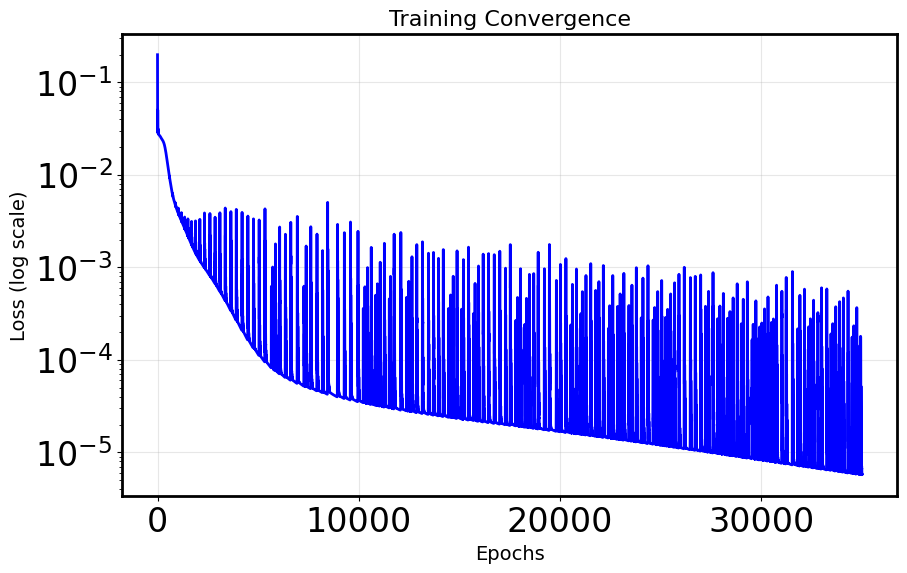

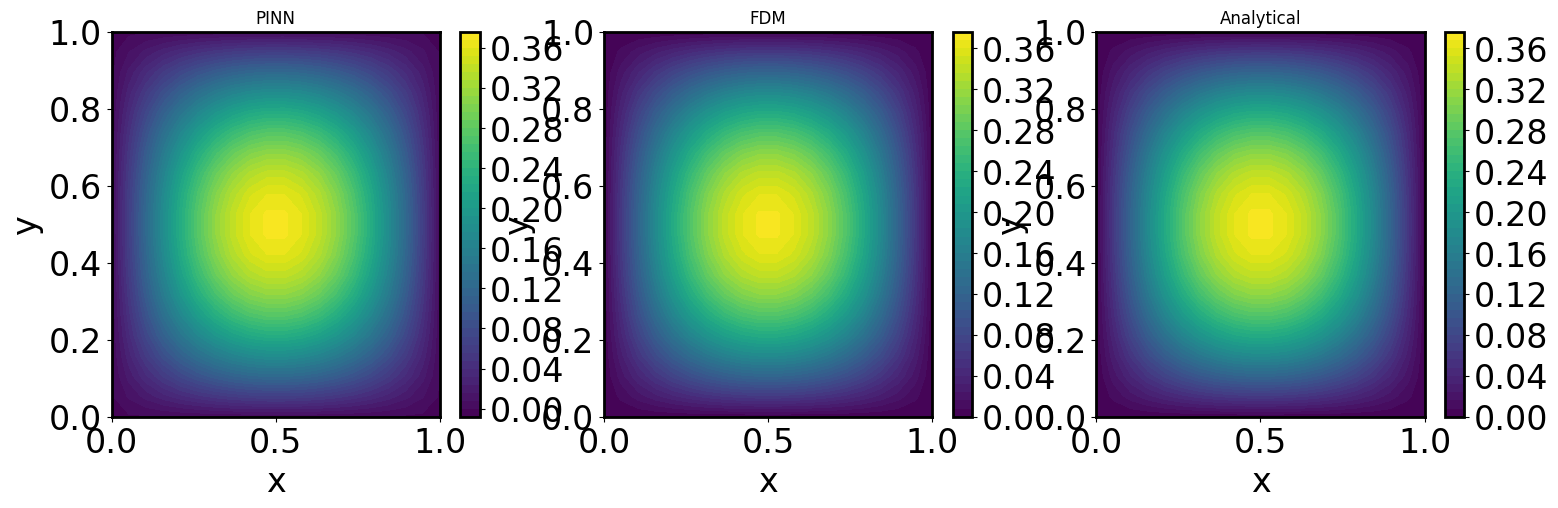

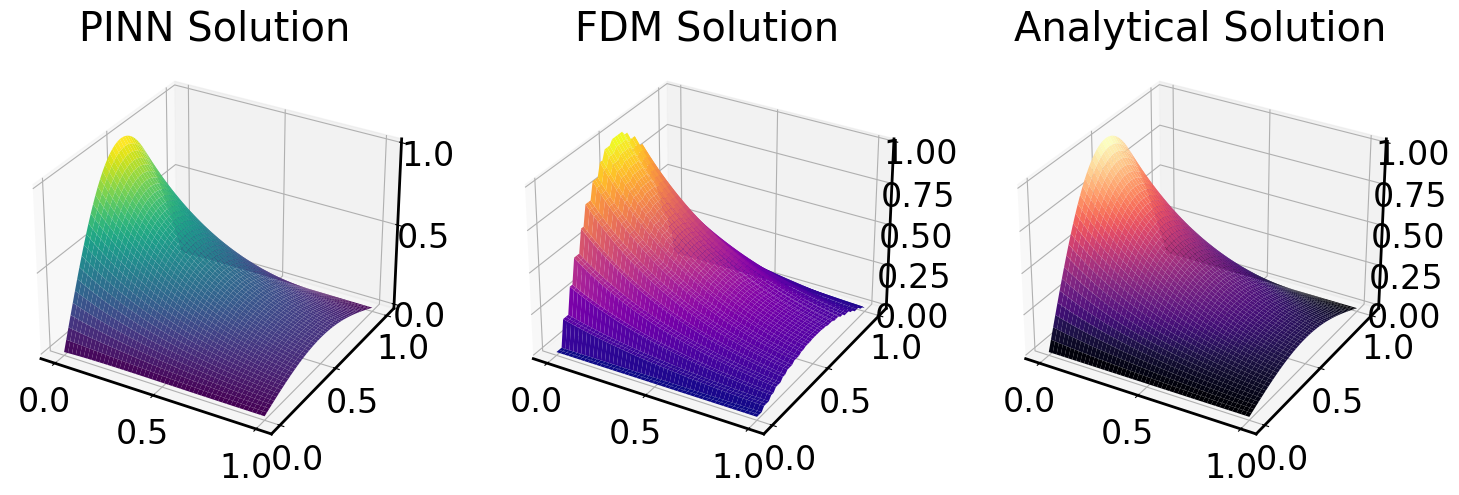

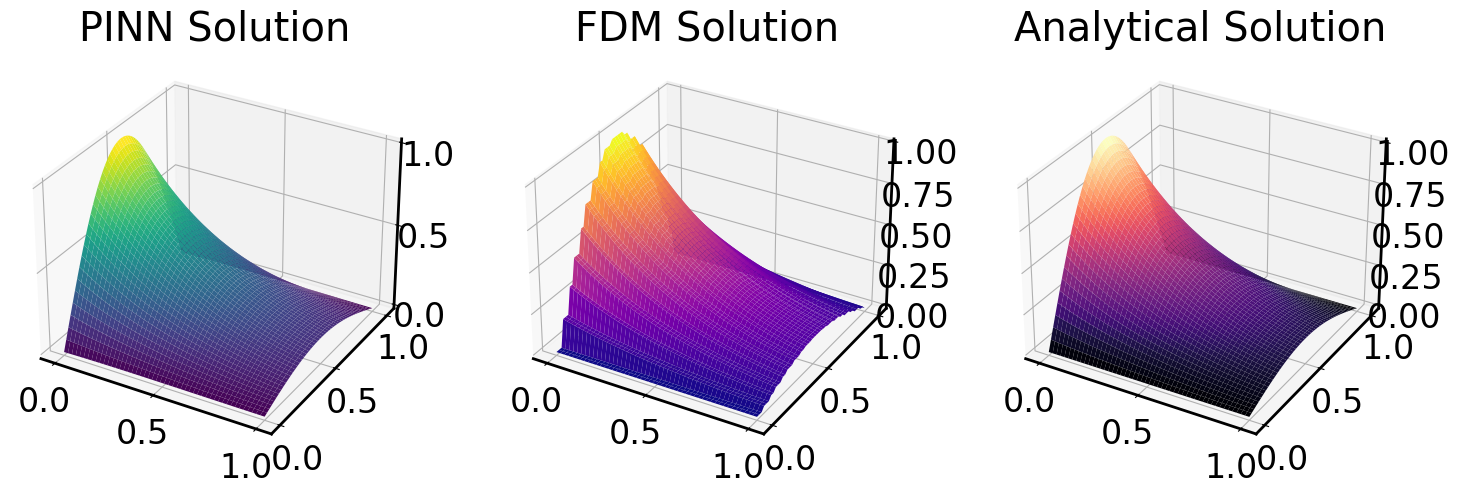

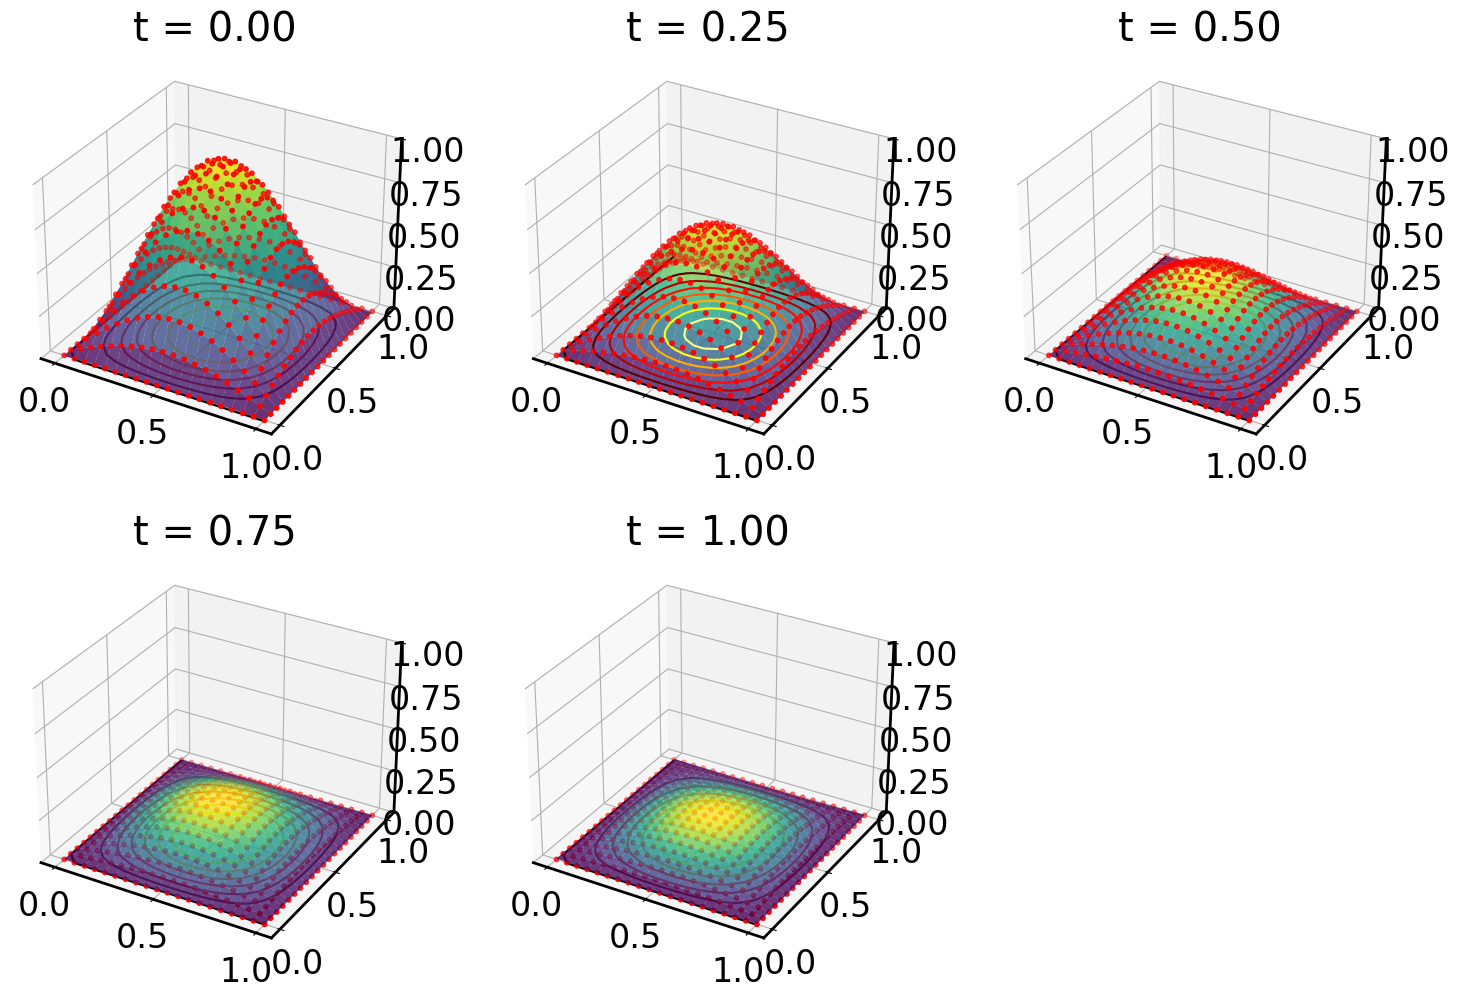

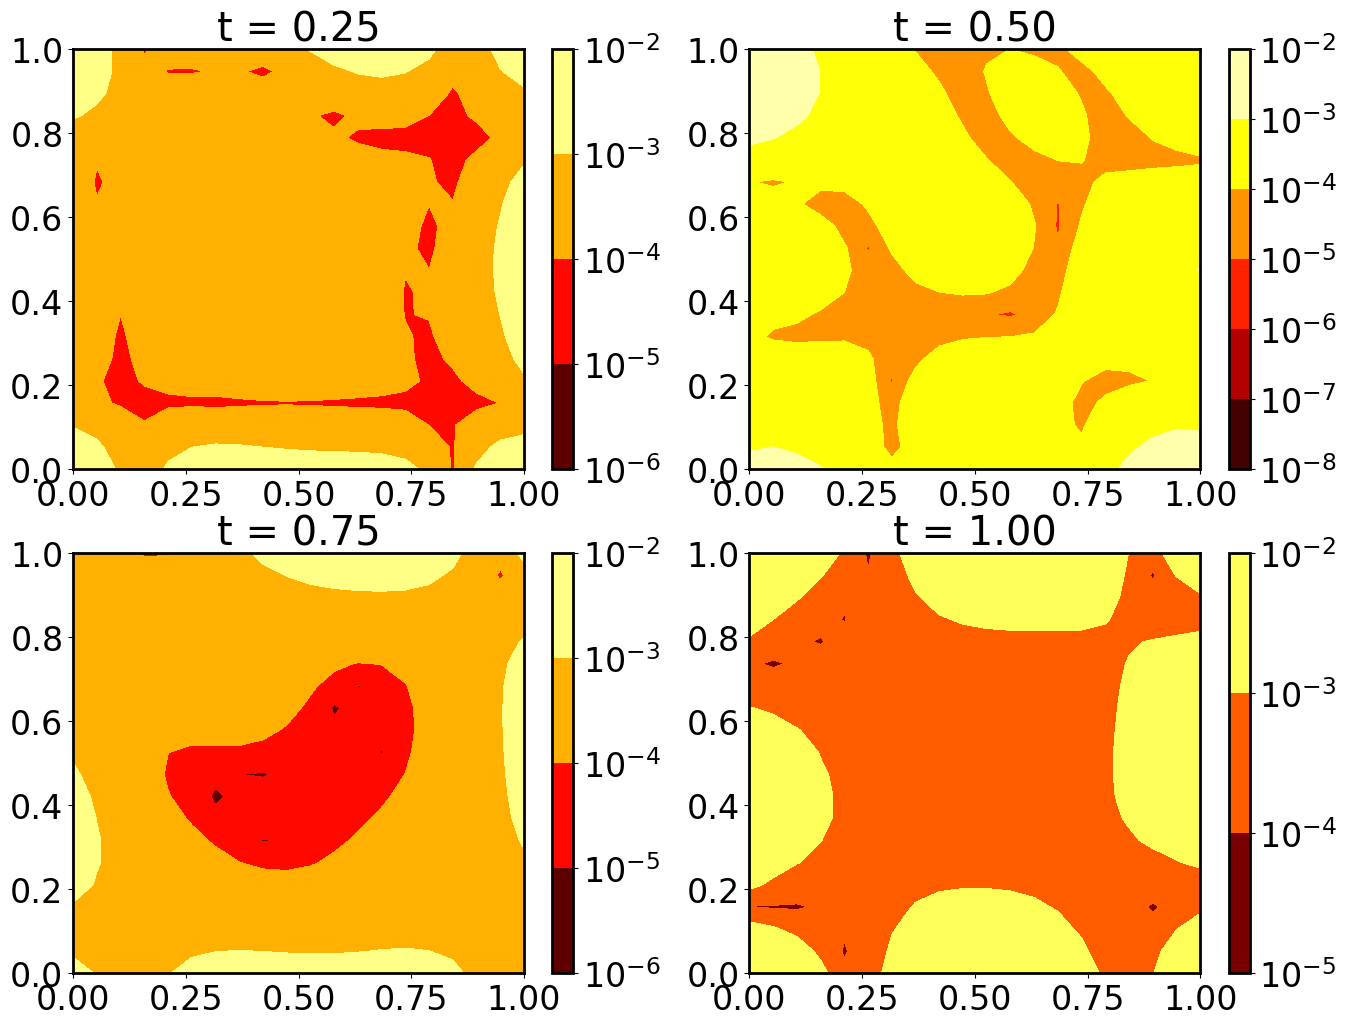

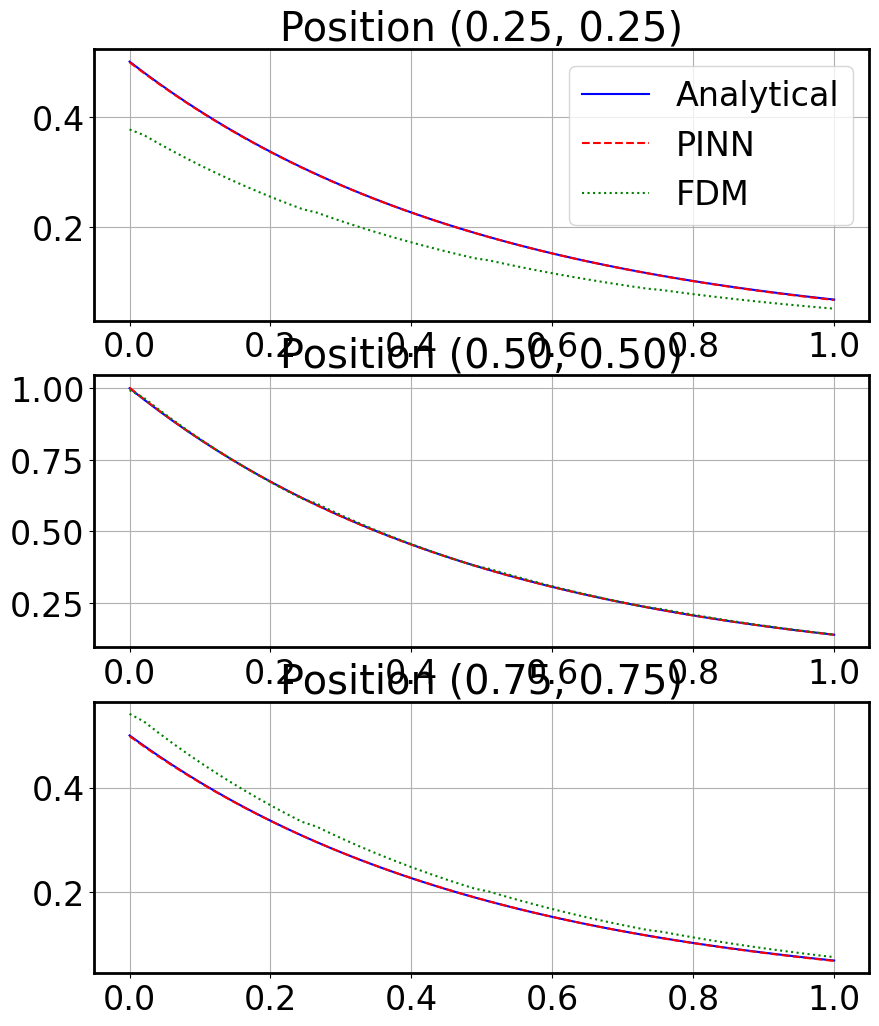

In [14]:

def analytical_solution(x, y, t, D):
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.exp(-2*D*(np.pi**2)*t)

def plot_convergence():
    plt.figure(figsize=(10,6))
    plt.semilogy(np.array(A_hist)[:,0], np.array(A_hist)[:,1], 'b-', lw=2)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss (log scale)', fontsize=14)
    plt.title('Training Convergence', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.savefig('convergence.png', dpi=300, bbox_inches='tight')

def plot_contour_comparison(t_val=0.5):
    X, Y = np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))
    m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

    # Get preds
    pinn_pred = eval_model(m).reshape(20,20)
    analytic = analytical_solution(X, Y, t_val, D)
    fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    titles = ['PINN', 'FDM', 'Analytical']
    data = [pinn_pred, u_fdm[fdm_idx], analytic]

    for ax, d, title in zip(axes, data, titles):
        cnt = ax.contourf(X, Y, d, levels=50, cmap='viridis')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(cnt, ax=ax)

    plt.savefig(f'contour_comparison_t_{t_val:.2f}.png', dpi=300)

def plot_model(fixed_var='x', fixed_val=0.5):
    fig = plt.figure(figsize=(18,6))
    var_names = {'x': (1,2), 'y': (0,2)}  # (varying dims, fixed dim)

    t = np.linspace(0,1,50)
    var = np.linspace(0,1,50)
    T, VAR = np.meshgrid(t, var)

    if fixed_var == 'x':
        coords = np.c_[fixed_val*np.ones_like(VAR.ravel()), VAR.ravel(), T.ravel()]
    else:
        coords = np.c_[VAR.ravel(), fixed_val*np.ones_like(VAR.ravel()), T.ravel()]

    pinn = eval_model(coords).reshape(50,50)
    analytic = analytical_solution(coords[:,0], coords[:,1], coords[:,2], D).reshape(50,50)

    fdm_vals = np.array([[np.interp(ti, t_fdm, u_fdm[:,int(fixed_val*19),int(varj*19)])
                        for ti in t] for varj in var])

    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(T, VAR, pinn, cmap='viridis')
    ax.set_title('PINN Solution')

    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(T, VAR, fdm_vals, cmap='plasma')
    ax.set_title('FDM Solution')

    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(T, VAR, analytic, cmap='magma')
    ax.set_title('Analytical Solution')

    plt.savefig(f'3d_comparison_fixed_{fixed_var}_{fixed_val:.2f}.png', dpi=300)

def plot_3d_surfaces():
    X, Y = np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))

    fig = plt.figure(figsize=(18,12))
    times = [0, 0.25, 0.5, 0.75, 1]

    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        m = np.hstack([X.ravel()[:,None], Y.ravel()[:,None], t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(t_val * (len(t_fdm)-1))

        surf = ax.plot_surface(X, Y, pinn, cmap='viridis', alpha=0.8)
        ax.contour(X, Y, analytic, zdir='z', offset=pinn.min(), cmap='hot')
        ax.scatter(X, Y, u_fdm[fdm_idx], c='r', s=10)

        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)

    plt.savefig('3d_surface_comparisons.png', dpi=300)

def plot_error_snapshots():
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    times = [0.25, 0.5, 0.75, 1.0]

    for idx, t_val in enumerate(times):
        ax = axes[idx//2, idx%2]
        X, Y = np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))
        m = np.hstack([X.ravel()[:,None], Y.ravel()[:,None], t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        err = np.abs(pinn - analytic)

        cnt = ax.contourf(X, Y, err, levels=50, cmap='hot', norm=mpl.colors.LogNorm())
        ax.set_title(f't = {t_val:.2f}')
        fig.colorbar(cnt, ax=ax)

    plt.savefig('error_snapshots.png', dpi=300)

def plot_temporal_evolution():
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axes = plt.subplots(3, 1, figsize=(10,12))

    for idx, (x_val, y_val) in enumerate(points):
        t = np.linspace(0,1,50)
        pinn = []
        analytic = []
        fdm = []

        for ti in t:
            m = np.array([[x_val, y_val, ti]])
            pinn.append(eval_model(m)[0])
            analytic.append(analytical_solution(x_val, y_val, ti, D))
            tidx = int(ti * (len(t_fdm)-1))
            fdm.append(u_fdm[tidx, int(x_val*19), int(y_val*19)])

        axes[idx].plot(t, analytic, 'b-', label='Analytical')
        axes[idx].plot(t, pinn, 'r--', label='PINN')
        axes[idx].plot(t, fdm, 'g:', label='FDM')
        axes[idx].set_title(f'Position ({x_val:.2f}, {y_val:.2f})')
        axes[idx].grid(True)
        if idx == 0:
            axes[idx].legend()

    plt.savefig('temporal_evolution.png', dpi=300)

# Gen all plots
plot_convergence()
plot_contour_comparison()
plot_model(fixed_var='x', fixed_val=0.5)
plot_model(fixed_var='y', fixed_val=0.5)
plot_3d_surfaces()
plot_error_snapshots()
plot_temporal_evolution()

In [3]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
import time
import scipy.special as sp
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc_dir(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_neumann(self, bc_neum, u_neum):
        loss_neum = 0.0
        # Loop over each Neumann boundary
        for key, pts in bc_neum.items():
            pts_tensor = nptoTensor(pts)
            pts_tensor.requires_grad = True
            u_pred = self.forward(pts_tensor)
            grad = torch.autograd.grad(u_pred, pts_tensor,
                                      grad_outputs=torch.ones_like(u_pred),
                                      create_graph=True)[0]
            if key == 'x1':  # enforce u_x=0 at x=1
                du_dx = grad[:, 0:1]
                loss_neum += self.loss_function(du_dx, nptoTensor(u_neum[key]))
            else:          # enforce u_y=0 at y=0 and y=1
                du_dy = grad[:, 1:2]
                loss_neum += self.loss_function(du_dy, nptoTensor(u_neum[key]))
        return loss_neum

    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [0]]
        u_yy = torch.autograd.grad(u_y, x_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, bc_dir, u_bc, bc_neum, u_neum, f_train):
        loss_dir = self.loss_bc_dir(nptoTensor(bc_dir), nptoTensor(u_bc))
        loss_neum = self.loss_neumann(bc_neum, u_neum)
        loss_f = self.loss_initernal(nptoTensor(f_train))
        return loss_dir + loss_neum + loss_f

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])

def trainingdata_transport(Nx, Ny, Nt, Nf):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)

    # IC: u(x,y,0)=0
    X, Y = np.meshgrid(x, y)
    IC_pts = np.hstack([X.flatten()[:, None], Y.flatten()[:, None], np.zeros((X.size, 1))])
    u_IC = np.zeros((X.size, 1))

    # Dirichlet BC on left: u(0,y,t)=1
    Y_dir, T_dir = np.meshgrid(y, t)
    X_dir = np.zeros_like(Y_dir)
    dir_pts = np.hstack([X_dir.flatten()[:, None], Y_dir.flatten()[:, None], T_dir.flatten()[:, None]])
    u_dir = np.ones((X_dir.size, 1))

    # Pack Dirichlet data (IC and left boundary) as before
    bc_dir = np.vstack([IC_pts, dir_pts])
    u_bc = np.vstack([u_IC, u_dir])

    # Neumann BCs
    # x=1: enforce u_x(1,y,t)=0
    Y_neum, T_neum = np.meshgrid(y, t)
    X_neum = np.ones_like(Y_neum)
    bc_neum = {}
    bc_neum['x1'] = np.hstack([X_neum.flatten()[:, None], Y_neum.flatten()[:, None], T_neum.flatten()[:, None]])
    neum_target_x = np.zeros((X_neum.size, 1))

    # y=0: enforce u_y(x,0,t)=0
    X_neum_y0, T_neum_y0 = np.meshgrid(x, t)
    Y_neum_y0 = np.zeros_like(X_neum_y0)
    bc_neum['y0'] = np.hstack([X_neum_y0.flatten()[:, None], Y_neum_y0.flatten()[:, None], T_neum_y0.flatten()[:, None]])
    neum_target_y0 = np.zeros((X_neum_y0.size, 1))

    # y=1: enforce u_y(x,1,t)=0
    X_neum_y1, T_neum_y1 = np.meshgrid(x, t)
    Y_neum_y1 = np.ones_like(X_neum_y1)
    bc_neum['y1'] = np.hstack([X_neum_y1.flatten()[:, None], Y_neum_y1.flatten()[:, None], T_neum_y1.flatten()[:, None]])
    neum_target_y1 = np.zeros((X_neum_y1.size, 1))

    # Pack Neumann targets into a dictionary
    u_neum = {'x1': neum_target_x, 'y0': neum_target_y0, 'y1': neum_target_y1}

    # Collocation points for PDE residual (unchanged)
    f_train = np.vstack((lhs(3, Nf), bc_dir))

    return bc_dir, u_bc, bc_neum, u_neum, f_train


N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
D = 0.1

# Generate training data
bc_dir_np, u_bc_np, bc_neum_np, u_neum_np, f_train_np = trainingdata_transport(N_x, N_y, N_t, N_f)
bc_dir = nptoTensor(bc_dir_np)
u_bc = nptoTensor(u_bc_np)
# Convert Neumann dict entries to tensors:
bc_neum = {key: nptoTensor(val) for key, val in bc_neum_np.items()}
u_neum = {key: nptoTensor(val) for key, val in u_neum_np.items()}
f_train = nptoTensor(f_train_np)

# Model setup
neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)

# Training loop
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
A_hist = []
max_iter = 35000
tic = time.time()
for i in range(max_iter):
    loss = mlp.loss(bc_dir, u_bc, bc_neum, u_neum, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1)%100==0:
         print(f"Epoch {i+1}: Loss = {loss.item():.6e}")

toc = time.time()
print(f'Total training time: {(toc - tic)/60:.2f} minutes')

# FDM Simulation
def run_2d_fdm_simulation():
    points = 20
    x = np.linspace(0, 1, points)
    y = np.linspace(0, 1, points)
    delta_x = x[1] - x[0]
    delta_y = y[1] - y[0]
    delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * D)
    t_points = int(1.0/delta_t)
    t = np.linspace(0, 1, t_points)
    u = np.zeros((len(t), len(x), len(y)))

    # Initial condition
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    u[0,1:-1,1:-1] = np.sin(np.pi*X) * np.sin(np.pi*Y)

    # Time integration
    for n in range(len(t)-1):
        for i in range(1, len(x)-1):
            for j in range(1, len(y)-1):
                u[n+1,i,j] = u[n,i,j] + delta_t*D*(
                    (u[n,i+1,j] - 2*u[n,i,j] + u[n,i-1,j])/delta_x**2 +
                    (u[n,i,j+1] - 2*u[n,i,j] + u[n,i,j-1])/delta_y**2
                )
        # Boundary conditions
        u[n+1,[0,-1],:] = 0
        u[n+1,:,[0,-1]] = 0
    return x, y, t, u

x_fdm, y_fdm, t_fdm, u_fdm = run_2d_fdm_simulation()

def analytical_solution(x, y, t, D, Nterms=50):
    # The solution is independent of y.
    sol = np.zeros_like(x)
    for n in range(Nterms):
        lam = (2*n+1)*np.pi/2
        sol += ((-1)**n/(2*n+1)) * np.sin(lam*x) * np.exp(-D*(lam**2)*t)
    return 1 - (4/np.pi)*sol

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

def plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25, 15))

    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6, label='PINN')
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3, label='Analytical')
        ax.plot_wireframe(X, Y, u_fdm[fdm_idx], color='black', alpha=0.5, label='FDM')
        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)
    plt.savefig('3D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

        err = np.abs(pinn - analytic)
        im = ax.imshow(err.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(np.array(A_hist)[:,0], np.array(A_hist)[:,1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm):
    fig, axs = plt.subplots(1, 3, figsize=(30,8))
    t_vals = [0.25, 0.5, 1.0]

    for idx, t_val in enumerate(t_vals):
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        err = np.abs(pinn - analytic)

        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                           origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm):
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10,15))

    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []

        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx = int(np.round(ti * (len(t_fdm)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_idx_y = np.argmin(np.abs(y_fdm - y_val))
            fdm_t.append(u_fdm[fdm_idx, fdm_idx_x, fdm_idx_y])

        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)
    plt.savefig('Temporal_Evolution.png', dpi=300)

# Generate all plots
plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm)
plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm)
plot_convergence_metrics()
plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm)
plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm)

# Save final model
path = '2D-Diffusion_PDE.pth'
torch.save(mlp.state_dict(), path)

cuda


TypeError: expected np.ndarray (got Tensor)

In [ ]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
import time
import scipy.special as sp
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc_dir(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_neumann(self, bc_neum, u_neum):
        loss_neum = 0.0
        # Loop over each Neumann boundary
        for key, pts in bc_neum.items():
            pts_tensor = nptoTensor(pts)
            pts_tensor.requires_grad = True
            u_pred = self.forward(pts_tensor)
            grad = torch.autograd.grad(u_pred, pts_tensor,
                                       grad_outputs=torch.ones_like(u_pred),
                                       create_graph=True)[0]
            if key == 'x1':  # u_x=0 @ x=1
                du_dx = grad[:, 0:1]
                loss_neum += self.loss_function(du_dx, nptoTensor(u_neum[key]))
            else:          # u_y=0 @ y=0 and y=1
                du_dy = grad[:, 1:2]
                loss_neum += self.loss_function(du_dy, nptoTensor(u_neum[key]))
        return loss_neum

    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [0]]
        u_yy = torch.autograd.grad(u_y, x_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, bc_dir, u_bc, bc_neum, u_neum, f_train):
        loss_dir = self.loss_bc_dir(nptoTensor(bc_dir), nptoTensor(u_bc))
        loss_neum = self.loss_neumann(bc_neum, u_neum)
        loss_f = self.loss_initernal(nptoTensor(f_train))
        return loss_dir + loss_neum + loss_f

def nptoTensor(data):
    # check if already torch.Tensor.
    if isinstance(data, torch.Tensor):
        return data.to(device).float()
    else:
        return torch.from_numpy(data).to(device).float()

def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])

def trainingdata_transport(Nx, Ny, Nt, Nf):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)

    # IC: u(x,y,0)=0
    X, Y = np.meshgrid(x, y)
    IC_pts = np.hstack([X.flatten()[:, None], Y.flatten()[:, None], np.zeros((X.size, 1))])
    u_IC = np.zeros((X.size, 1))

    # Dirichlet BC on left: u(0,y,t)=1
    Y_dir, T_dir = np.meshgrid(y, t)
    X_dir = np.zeros_like(Y_dir)
    dir_pts = np.hstack([X_dir.flatten()[:, None], Y_dir.flatten()[:, None], T_dir.flatten()[:, None]])
    u_dir = np.ones((X_dir.size, 1))

    # Pack Dirichlet data (IC and left boundary)
    bc_dir = np.vstack([IC_pts, dir_pts])
    u_bc = np.vstack([u_IC, u_dir])

    # Neumann BCs (right, bottom, top):
    # x=1
    Y_neum, T_neum = np.meshgrid(y, t)
    X_neum = np.ones_like(Y_neum)
    bc_neum = {}
    bc_neum['x1'] = np.hstack([X_neum.flatten()[:, None], Y_neum.flatten()[:, None], T_neum.flatten()[:, None]])
    neum_target_x = np.zeros((X_neum.size, 1))

    # y=0
    X_neum_y0, T_neum_y0 = np.meshgrid(x, t)
    Y_neum_y0 = np.zeros_like(X_neum_y0)
    bc_neum['y0'] = np.hstack([X_neum_y0.flatten()[:, None], Y_neum_y0.flatten()[:, None], T_neum_y0.flatten()[:, None]])
    neum_target_y0 = np.zeros((X_neum_y0.size, 1))

    # y=1
    X_neum_y1, T_neum_y1 = np.meshgrid(x, t)
    Y_neum_y1 = np.ones_like(X_neum_y1)
    bc_neum['y1'] = np.hstack([X_neum_y1.flatten()[:, None], Y_neum_y1.flatten()[:, None], T_neum_y1.flatten()[:, None]])
    neum_target_y1 = np.zeros((X_neum_y1.size, 1))

    u_neum = {'x1': neum_target_x, 'y0': neum_target_y0, 'y1': neum_target_y1}

    f_train = np.vstack((lhs(3, Nf), bc_dir))

    return bc_dir, u_bc, bc_neum, u_neum, f_train

N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
D = 0.1

# Generate training data
bc_dir_np, u_bc_np, bc_neum_np, u_neum_np, f_train_np = trainingdata_transport(N_x, N_y, N_t, N_f)
bc_dir = nptoTensor(bc_dir_np)
u_bc = nptoTensor(u_bc_np)
bc_neum = {key: nptoTensor(val) for key, val in bc_neum_np.items()}
u_neum = {key: nptoTensor(val) for key, val in u_neum_np.items()}
f_train = nptoTensor(f_train_np)

# Model setup
neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)

# Training loop
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
A_hist = []
max_iter = 35000
tic = time.time()
for i in range(max_iter):
    loss = mlp.loss(bc_dir, u_bc, bc_neum, u_neum, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
         print(f"Epoch {i+1}: Loss = {loss.item():.6e}")

toc = time.time()
print(f'Total training time: {(toc - tic)/60:.2f} minutes')

# FDM Simulation for comparison
def run_2d_fdm_simulation():
    points = 20
    x = np.linspace(0, 1, points)
    y = np.linspace(0, 1, points)
    delta_x = x[1] - x[0]
    delta_y = y[1] - y[0]
    delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * D)
    t_points = int(1.0/delta_t)
    t = np.linspace(0, 1, t_points)
    u = np.zeros((len(t), len(x), len(y)))

    # Initial condition for FDM (using a sine function for comparison)
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    u[0, 1:-1, 1:-1] = np.sin(np.pi * X) * np.sin(np.pi * Y)

    # Time integration
    for n in range(len(t)-1):
        for i in range(1, len(x)-1):
            for j in range(1, len(y)-1):
                u[n+1, i, j] = u[n, i, j] + delta_t * D * (
                    (u[n, i+1, j] - 2*u[n, i, j] + u[n, i-1, j])/(delta_x**2) +
                    (u[n, i, j+1] - 2*u[n, i, j] + u[n, i, j-1])/(delta_y**2)
                )
        # Boundary conditions: homogeneous Dirichlet
        u[n+1, [0, -1], :] = 0
        u[n+1, :, [0, -1]] = 0
    return x, y, t, u

x_fdm, y_fdm, t_fdm, u_fdm = run_2d_fdm_simulation()

def analytical_solution(x, y, t, D, Nterms=50):
    sol = np.zeros_like(x)
    for n in range(Nterms):
        lam = (2*n+1)*np.pi/2
        sol += ((-1)**n/(2*n+1)) * np.sin(lam*x) * np.exp(-D*(lam**2)*t)
    return 1 - (4/np.pi)*sol

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

def plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25, 15))
    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), t_val*np.ones((X.size, 1))])
        pinn = eval_model(m).reshape(len(y_fdm), len(x_fdm))
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))
        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6)
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3)
        ax.plot_wireframe(X, Y, u_fdm[fdm_idx], color='black', alpha=0.5)
        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0, 1)
    plt.savefig('3D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), t_val*np.ones((X.size, 1))])
        pinn = eval_model(m).reshape(len(y_fdm), len(x_fdm))
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))
        err = np.abs(pinn - analytic)
        im = ax.imshow(err.T, origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.semilogy(np.array(A_hist)[:, 0], np.array(A_hist)[:, 1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm):
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    t_vals = [0.25, 0.5, 1.0]
    for idx, t_val in enumerate(t_vals):
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), t_val*np.ones((X.size, 1))])
        pinn = eval_model(m).reshape(len(y_fdm), len(x_fdm))
        analytic = analytical_solution(X, Y, t_val, D)
        err = np.abs(pinn - analytic)
        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                             origin='lower', extent=[0, 1, 0, 1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm):
    points = [(0.25, 0.25), (0.5, 0.5), (0.75, 0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []
        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx = int(np.round(ti * (len(t_fdm)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_idx_y = np.argmin(np.abs(y_fdm - y_val))
            fdm_t.append(u_fdm[fdm_idx, fdm_idx_x, fdm_idx_y])
        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)
    plt.savefig('Temporal_Evolution.png', dpi=300)

# Generate all plots
plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm)
plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm)
plot_convergence_metrics()
plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm)
plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm)

# Save final model
path = '2D-Diffusion_PDE.pth'
torch.save(mlp.state_dict(), path)


cuda


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100: Loss = 4.793625e-02
Epoch 200: Loss = 3.172293e-02
Epoch 300: Loss = 2.037705e-02
Epoch 400: Loss = 1.588653e-02
Epoch 500: Loss = 1.401690e-02
Epoch 600: Loss = 1.381402e-02
Epoch 700: Loss = 1.202405e-02
Epoch 800: Loss = 1.256558e-02
Epoch 900: Loss = 1.056096e-02
Epoch 1000: Loss = 1.015277e-02
Epoch 1100: Loss = 9.482817e-03
Epoch 1200: Loss = 9.145538e-03
Epoch 1300: Loss = 8.844603e-03
Epoch 1400: Loss = 8.643646e-03
Epoch 1500: Loss = 8.441773e-03
Epoch 1600: Loss = 8.298457e-03
Epoch 1700: Loss = 8.160982e-03
Epoch 1800: Loss = 8.055273e-03
Epoch 1900: Loss = 7.956153e-03
Epoch 2000: Loss = 7.859163e-03
Epoch 2100: Loss = 7.873897e-03
Epoch 2200: Loss = 7.698070e-03
Epoch 2300: Loss = 7.632233e-03
Epoch 2400: Loss = 7.570330e-03
Epoch 2500: Loss = 7.515053e-03
Epoch 2600: Loss = 7.509153e-03
Epoch 2700: Loss = 7.684182e-03
Epoch 2800: Loss = 7.745419e-03
Epoch 2900: Loss = 7.389394e-03
Epoch 3000: Loss = 7.334198e-03
Epoch 3100: Loss = 7.280663e-03
Epoch 3200: Loss 